# 03 Python + MR 实现Hadoop Streaming分区和二次排序
---

## 1. 实验目的

基于MapReduce思想，编写分区（Partition）和二次排序（Secondary Sorting）程序

## 2. 实验要求

理解MapReduce编程思想，会用Python编写基于HadoopStreaming的MapReduce分区和二次排序程序，然后将其在本地测试并在Hadoop集群上执行并分析执行过程。

## 3. 实验原理

HadoopStreaming框架默认情况下会以’\t’作为分隔符，将每行第一个’\t’之前的部分作为key，其余内容作为value， 
如果没有’\t’分隔符，则整行作为key；这个{key}\t{value}对又作为该map对应的reduce的输入。

HadoopStreaming提供以下参数来实现对map输出进行分区：

* -D stream.map.output.field.separator: 指定分割key分隔符，默认是'\t'
* -D stream.num.map.output.key.fields: 用作key的字段 
* -D map.output.key.field.separator: 指定key内部的分隔符 
* -D num.key.fields.for.partition: 指定对key分出来的前几部分做partition而不是整个key

MR默认会对键进行排序，然后有时候也需要对值进行排序，满足这种需求的一种方法是在reduce阶段排序收集过来的values，但如果有数量巨大的values可能就会导致内存溢出等问题，这就是二次排序的应用场景--将对值的排序也安排到MR计算过程之中，而非单独来做。

二次排序就是首先按照第一字段排序，然后再对第一次字段相同的行按照第二字段排序，注意不能破坏第一次排序的结果。

mapper的输出被分区到各个reducer之后，会有一步排序。默认是按照key做二次排序，如果key是多列组成，先按照第一列排序，第一列相同的，按照第二列排序，依此类推。

如果需要自定义排序，这里要指定key内部的哪些元素用来做排序依据，是排字典序还是数字序，倒序还是正序。用来控制的参数是 mapred.text.key.comparator.options，
可通过org.apache.hadoop.mapred.lib.KeyFieldBasedComparator来自定义使用key中的部分字段做比较。


## 4. 实验步骤

### 1）准备数据

#### 需要按注册地（省）进行分区的车牌数据

数据的每行分别为：车牌号,注册地,里程数

```
鲁V73930,鲁,549 
黑ML1711,黑,235 
鲁V75066,鲁,657 
桂J73031,桂,900 
晋M42387,晋,432 
桂J73138,桂,456 
晋M41665,晋,879 
晋M42529,晋,790
```

#### 需要按注册地（省）分区并按序号二次排序的车牌数据

数据的每行分别为：车牌号,注册地,序号,里程数
```
鲁V73930,鲁,2,549 
黑ML1711,黑,1,235 
鲁V75066,鲁,1,657 
桂J73031,桂,1,900 
晋M42387,晋,3,432 
桂J73138,桂,2,456 
晋M41665,晋,2,879 
晋M42529,晋,1,790
鲁V75530,鲁,3,569
```
### 2）编写程序

#### 1. 分区（Partition）

##### mapper（plate_partition_mapper.py）

In [17]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import sys

def main():    
    for line in sys.stdin:
        line = line.strip()
        row = line.split(",")
        if len(row) >= 3:
            plate  = row[0]   # 车牌号
            province = row[1] # 注册地
            mile = row[2]     # 里程
            print(province + "," + plate + "\t" + mile) 

if __name__ == '__main__':
    main()

##### reducer（plate_partition_reducer.py）

In [15]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import sys

def main():
    prov = None
    sum_mile = 0

    for line in sys.stdin:
        line = line.strip()
        row, mile = line.split("\t")
        mile = int(mile)
        if prov == None:
            prov = row[0].split(",")[0]
            sum_mile = mile
        else:
            if prov == row[0].split(",")[0]:
                # 相同组
                sum_mile += mile
            else:
                # 不同组，输出上一组数据
                print('{0}\t{1}'.format(prov, sum_mile))
                sum_mile = mile
                prov = row[0].split(",")[0]

    print('{0}\t{1}'.format(prov, sum_mile))

if __name__ == '__main__':
    main()

None	0


#### 2. 二次排序（Secondary Sorting）

##### mapper（plate_secsort_mapper.py）

In [11]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
import sys

def main():
    for line in sys.stdin:
        line = line.strip()
        row = line.split(",")
        if len(row) >= 3:
            plate  = row[0]   # 车牌号
            province = row[1] # 注册地
            order = row[2]    # 序号
            mile = row[3]     # 里程
            print(",".join([province, plate, order, mile]))
            
if __name__ == '__main__':
    main()

##### reducer（plate_secsort_reducer.py）

In [ ]:
#!/usr/bin/python
# -*- coding: utf-8 -*-
import sys

def main():
    # 几乎什么都不用做
    for line in sys.stdin:
        line = line.strip()
        print line

if __name__ == '__main__':
    main()

### 3）本地测试

#### 1. 测试分区

In [228]:
!cat data/plates_data1.txt

鲁V73930,鲁,549 
黑ML1711,黑,235 
鲁V75066,鲁,657 
桂J73031,桂,900 
晋M42387,晋,432 
桂J73138,桂,456 
晋M41665,晋,879 
晋M42529,晋,790

In [229]:
!cat data/plates_data1.txt | \
python input_files/plate_partition_mapper.py | \
sort

桂,桂J73031	900
桂,桂J73138	456
晋,晋M41665	879
晋,晋M42387	432
晋,晋M42529	790
黑,黑ML1711	235
鲁,鲁V73930	549
鲁,鲁V75066	657


In [230]:
!cat data/plates_data1.txt | \
python input_files/plate_partition_mapper.py | \
sort | \
python input_files/plate_partition_reducer.py 

桂	1356
晋	2101
黑	235
鲁	1206


#### 2. 测试二次排序

In [231]:
!cat data/plates_data2.txt

鲁V73930,鲁,2,549 
黑ML1711,黑,1,235 
鲁V75066,鲁,1,657 
桂J73031,桂,1,900 
晋M42387,晋,3,432 
桂J73138,桂,2,456 
晋M41665,晋,2,879 
晋M42529,晋,1,790
鲁V75530,鲁,3,569

In [232]:
!cat data/plates_data2.txt | \
python input_files/plate_secsort_mapper.py | \
sort | \
python input_files/plate_secsort_reducer.py 

桂,桂J73031,1,900
桂,桂J73138,2,456
晋,晋M41665,2,879
晋,晋M42387,3,432
晋,晋M42529,1,790
黑,黑ML1711,1,235
鲁,鲁V73930,2,549
鲁,鲁V75066,1,657
鲁,鲁V75530,3,569


In [233]:
!ls -l input_files/

total 80
drwxr-xr-x  3 xiaobai  staff    96  8 13 13:02 data
-rwxr-xr-x  1 xiaobai  staff   386  8 13 13:08 plate_partition_mapper.py
-rwxr-xr-x  1 xiaobai  staff   717  8 13 13:08 plate_partition_reducer.py
-rw-r--r--  1 xiaobai  staff   761  8 13 15:05 plate_partition_run.sh
-rw-r--r--  1 xiaobai  staff   449  8 13 11:32 plate_secsort_mapper.py
-rw-r--r--  1 xiaobai  staff   210  8 13 11:37 plate_secsort_reducer.py
-rwxr-xr-x  1 xiaobai  staff   982  8 13 15:33 plate_secsort_run.sh
-rwxr-xr-x  1 xiaobai  staff   568  8 12 16:42 stock_mapper.py
-rwxr-xr-x  1 xiaobai  staff   758  8 12 16:43 stock_reducer.py
-rwxr-xr-x  1 xiaobai  staff   603  8 11 17:39 word_count_mapper.py
-rwxr-xr-x  1 xiaobai  staff  1144  8 12 12:08 word_count_reducer.py


### 4）集群运行

#### 1. 运行分区程序
##### 编写启动脚本（plate_partition_run.sh）

由于提交MapReduce作业的命令非常很长，参数很多，编写Shell启动脚本是一种高效的方法：

In [236]:
!cat input_files/plate_partition_run.sh

#!/bin/bash
EXEC_PATH=$(dirname "$0")
HP_CMD=hadoop
JAR_PACKAGE=/usr/hadoop-2.8.3/share/hadoop/tools/lib/hadoop-streaming-2.8.3.jar
IN_PATH=/input/plates_data1.txt
OUT_PATH=/output/plates_part
MAP_FILE=${EXEC_PATH}/plate_partition_mapper.py
RED_FILE=${EXEC_PATH}/plate_partition_reducer.py
$HP_CMD fs -rm -r $OUT_PATH
$HP_CMD jar $JAR_PACKAGE \
-D mapred.job.queue.name=bdev \
-D stream.map.input.ignoreKey=true \
-D map.output.key.field.separator=, \
-D num.key.fields.for.partition=1 \
-numReduceTasks 1 \
-input $IN_PATH \
-output $OUT_PATH \
-file $MAP_FILE \
-file $RED_FILE \
-mapper $MAP_FILE \
-reducer $RED_FILE \
-partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner
$HP_CMD fs -ls $OUT_PATH

In [33]:
!docker exec namenode \
chmod +x /input_files/plate_partition_run.sh

In [74]:
!docker exec namenode \
chmod +x /input_files/plate_partition_mapper.py

In [75]:
!docker exec namenode \
chmod +x /input_files/plate_partition_reducer.py

In [234]:
!docker exec namenode \
ls /opt/hadoop-2.7.1/share/hadoop/tools/lib | \
grep 'stream'

hadoop-streaming-2.7.1.jar


##### 上传数据文件到 hadoop 集群并提交 MR Job

In [61]:
!mkdir ./input_files/data

In [63]:
!cp ./data/plates_data1.txt ./input_files/data

In [64]:
!docker exec namenode \
hadoop fs -mkdir /input 

In [68]:
!docker exec namenode \
hadoop fs -ls /

Found 2 items
drwxr-xr-x   - root supergroup          0 2019-08-13 05:03 /input
drwxr-xr-x   - root supergroup          0 2019-08-11 12:20 /rmstate


In [98]:
!docker exec namenode \
hadoop fs -put /input_files/data/plates_data1.txt /input

In [101]:
!docker exec namenode \
hadoop fs -ls /input

Found 1 items
-rw-r--r--   3 root supergroup        150 2019-08-13 05:05 /input/plates_data1.txt


In [111]:
#!docker exec namenode /input_files/plate_partition_run.sh

In [106]:
!docker cp ./input_files/data/plates_data1.txt master:/root/

In [85]:
!docker cp ./input_files/plate_partition_mapper.py master:/root/

In [86]:
!docker cp ./input_files/plate_partition_reducer.py master:/root/

In [95]:
!docker cp ./input_files/plate_partition_run.sh master:/root/

In [107]:
!docker exec master \
hadoop fs -put /root/plates_data1.txt /input/

put: `/input/plates_data1.txt': File exists


In [237]:
!docker exec master \
/root/plate_partition_run.sh

19/08/13 12:03:19 INFO Configuration.deprecation: io.bytes.per.checksum is deprecated. Instead, use dfs.bytes-per-checksum
Deleted /output/plates_part
19/08/13 12:03:20 WARN streaming.StreamJob: -file option is deprecated, please use generic option -files instead.
packageJobJar: [/root/plate_partition_mapper.py, /root/plate_partition_reducer.py] [] /tmp/streamjob3031390533179335376.jar tmpDir=null
19/08/13 12:03:22 INFO Configuration.deprecation: session.id is deprecated. Instead, use dfs.metrics.session-id
19/08/13 12:03:22 INFO jvm.JvmMetrics: Initializing JVM Metrics with processName=JobTracker, sessionId=
19/08/13 12:03:22 INFO jvm.JvmMetrics: Cannot initialize JVM Metrics with processName=JobTracker, sessionId= - already initialized
19/08/13 12:03:22 INFO mapred.FileInputFormat: Total input files to process : 1
19/08/13 12:03:22 INFO mapreduce.JobSubmitter: number of splits:1
19/08/13 12:03:22 INFO Configuration.deprecation: mapred.job.queue.name is deprecated. Instead, use mapred

19/08/13 12:03:25 INFO reduce.LocalFetcher: localfetcher#1 about to shuffle output of map attempt_local1201774250_0001_m_000000_0 decomp: 102 len: 106 to MEMORY
19/08/13 12:03:25 INFO reduce.InMemoryMapOutput: Read 102 bytes from map-output for attempt_local1201774250_0001_m_000000_0
19/08/13 12:03:25 INFO reduce.MergeManagerImpl: closeInMemoryFile -> map-output of size: 102, inMemoryMapOutputs.size() -> 1, commitMemory -> 0, usedMemory ->102
19/08/13 12:03:25 INFO reduce.EventFetcher: EventFetcher is interrupted.. Returning
19/08/13 12:03:25 INFO mapred.LocalJobRunner: 1 / 1 copied.
19/08/13 12:03:25 INFO reduce.MergeManagerImpl: finalMerge called with 1 in-memory map-outputs and 0 on-disk map-outputs
19/08/13 12:03:25 INFO mapred.Merger: Merging 1 sorted segments
19/08/13 12:03:25 INFO mapred.Merger: Down to the last merge-pass, with 1 segments left of total size: 86 bytes
19/08/13 12:03:25 INFO reduce.MergeManagerImpl: Merged 1 segments, 102 bytes to disk to satisfy reduce memory li

19/08/13 12:03:26 INFO mapreduce.Job: Job job_local1201774250_0001 completed successfully
19/08/13 12:03:27 INFO mapreduce.Job: Counters: 30
	File System Counters
		FILE: Number of bytes read=7747
		FILE: Number of bytes written=1135564
		FILE: Number of read operations=0
		FILE: Number of large read operations=0
		FILE: Number of write operations=0
	Map-Reduce Framework
		Map input records=8
		Map output records=8
		Map output bytes=144
		Map output materialized bytes=172
		Input split bytes=80
		Combine input records=0
		Combine output records=0
		Reduce input groups=8
		Reduce shuffle bytes=172
		Reduce input records=8
		Reduce output records=4
		Spilled Records=16
		Shuffled Maps =2
		Failed Shuffles=0
		Merged Map outputs=2
		GC time elapsed (ms)=17
		Total committed heap usage (bytes)=568328192
	Shuffle Errors
		BAD_ID=0
		CONNECTION=0
		IO_ERROR=0
		WRONG_LENGTH=0
		WRONG_MAP=0
		WRONG_REDUCE=0
	File Input Format Counters 
		Bytes Read=170
	File Output Format Counters 
		Bytes W

In [238]:
!docker exec master \
hadoop fs -cat /output/plates_part/part-00000

晋	2101
鲁	1206


In [239]:
!docker exec master \
hadoop fs -cat /output/plates_part/part-00001

桂	1356
黑	235


#### 2. 运行二次排序

##### 编写启动脚本（plate_secsort_run.sh）

In [257]:
!cat input_files/plate_secsort_run.sh

#!/bin/bash
EXEC_PATH=$(dirname "$0")
HP_CMD=hadoop
JAR_PACKAGE=/usr/hadoop-2.8.3/share/hadoop/tools/lib/hadoop-streaming-2.8.3.jar
IN_PATH=/input/plates_data2.txt
OUT_PATH=/output/plates_secsort
MAP_FILE=${EXEC_PATH}/plate_secsort_mapper.py
RED_FILE=${EXEC_PATH}/plate_secsort_reducer.py
$HP_CMD fs -rm -r $OUT_PATH
$HP_CMD jar $JAR_PACKAGE \
-D mapred.job.queue.name=bdev \
-D stream.map.input.ignoreKey=true \
-D stream.map.output.field.separator=, \
-D stream.num.map.output.key.fields=3 \
-D map.output.key.field.separator=, \
-D num.key.fields.for.partition=1 \
-D mapred.output.key.comparator.class=\
org.apache.hadoop.mapred.lib.KeyFieldBasedComparator \
-D mapred.text.key.comparator.options=-k3,3nr \
-numReduceTasks 5 \
-input $IN_PATH \
-output $OUT_PATH \
-file $MAP_FILE \
-file $RED_FILE \
-mapper $MAP_FILE \
-reducer $RED_FILE \
-partitioner org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner
$HP_CMD fs -ls $OUT_PATH

In [113]:
!docker cp data/plates_data2.txt master:/root/

In [114]:
!docker cp input_files/plate_secsort_mapper.py master:/root/

In [115]:
!docker cp input_files/plate_secsort_reducer.py master:/root/

In [258]:
!docker cp input_files/plate_secsort_run.sh master:/root/

##### 上传数据到 hadoop 集群并提交 MR Job

In [117]:
!docker exec master \
hadoop fs -put /root/plates_data2.txt /input/

In [259]:
!docker exec master \
chmod +x /root/plate_secsort_run.sh

In [260]:
!docker exec master \
/root/plate_secsort_run.sh

19/08/13 12:12:16 INFO Configuration.deprecation: io.bytes.per.checksum is deprecated. Instead, use dfs.bytes-per-checksum
Deleted /output/plates_secsort
19/08/13 12:12:17 WARN streaming.StreamJob: -file option is deprecated, please use generic option -files instead.
packageJobJar: [/root/plate_secsort_mapper.py, /root/plate_secsort_reducer.py] [] /tmp/streamjob6141640170064330830.jar tmpDir=null
19/08/13 12:12:18 INFO Configuration.deprecation: session.id is deprecated. Instead, use dfs.metrics.session-id
19/08/13 12:12:18 INFO jvm.JvmMetrics: Initializing JVM Metrics with processName=JobTracker, sessionId=
19/08/13 12:12:18 INFO jvm.JvmMetrics: Cannot initialize JVM Metrics with processName=JobTracker, sessionId= - already initialized
19/08/13 12:12:19 INFO mapred.FileInputFormat: Total input files to process : 1
19/08/13 12:12:19 INFO mapreduce.JobSubmitter: number of splits:1
19/08/13 12:12:19 INFO Configuration.deprecation: mapred.job.queue.name is deprecated. Instead, use mapredu

19/08/13 12:12:21 INFO reduce.EventFetcher: attempt_local234080687_0001_r_000000_0 Thread started: EventFetcher for fetching Map Completion Events
19/08/13 12:12:21 INFO reduce.LocalFetcher: localfetcher#1 about to shuffle output of map attempt_local234080687_0001_m_000000_0 decomp: 90 len: 94 to MEMORY
19/08/13 12:12:21 INFO reduce.InMemoryMapOutput: Read 90 bytes from map-output for attempt_local234080687_0001_m_000000_0
19/08/13 12:12:21 INFO reduce.MergeManagerImpl: closeInMemoryFile -> map-output of size: 90, inMemoryMapOutputs.size() -> 1, commitMemory -> 0, usedMemory ->90
19/08/13 12:12:21 WARN io.ReadaheadPool: Failed readahead on ifile
EBADF: Bad file descriptor
	at org.apache.hadoop.io.nativeio.NativeIO$POSIX.posix_fadvise(Native Method)
	at org.apache.hadoop.io.nativeio.NativeIO$POSIX.posixFadviseIfPossible(NativeIO.java:267)
	at org.apache.hadoop.io.nativeio.NativeIO$POSIX$CacheManipulator.posixFadviseIfPossible(NativeIO.java:146)
	at org.apache.hadoop.io.ReadaheadPool$Rea

19/08/13 12:12:21 INFO reduce.LocalFetcher: localfetcher#3 about to shuffle output of map attempt_local234080687_0001_m_000000_0 decomp: 68 len: 72 to MEMORY
19/08/13 12:12:21 INFO reduce.InMemoryMapOutput: Read 68 bytes from map-output for attempt_local234080687_0001_m_000000_0
19/08/13 12:12:21 INFO reduce.MergeManagerImpl: closeInMemoryFile -> map-output of size: 68, inMemoryMapOutputs.size() -> 1, commitMemory -> 0, usedMemory ->68
19/08/13 12:12:21 INFO reduce.EventFetcher: EventFetcher is interrupted.. Returning
19/08/13 12:12:21 INFO mapred.LocalJobRunner: 1 / 1 copied.
19/08/13 12:12:21 INFO reduce.MergeManagerImpl: finalMerge called with 1 in-memory map-outputs and 0 on-disk map-outputs
19/08/13 12:12:21 INFO mapred.Merger: Merging 1 sorted segments
19/08/13 12:12:21 INFO mapred.Merger: Down to the last merge-pass, with 1 segments left of total size: 50 bytes
19/08/13 12:12:21 INFO reduce.MergeManagerImpl: Merged 1 segments, 68 bytes to disk to satisfy reduce memory limit
19/0

19/08/13 12:12:22 INFO streaming.PipeMapRed: MRErrorThread done
19/08/13 12:12:22 INFO streaming.PipeMapRed: mapRedFinished
19/08/13 12:12:22 INFO mapred.Task: Task:attempt_local234080687_0001_r_000004_0 is done. And is in the process of committing
19/08/13 12:12:22 INFO mapred.LocalJobRunner: 1 / 1 copied.
19/08/13 12:12:22 INFO mapred.Task: Task attempt_local234080687_0001_r_000004_0 is allowed to commit now
19/08/13 12:12:22 INFO output.FileOutputCommitter: Saved output of task 'attempt_local234080687_0001_r_000004_0' to file:/output/plates_secsort/_temporary/0/task_local234080687_0001_r_000004
19/08/13 12:12:22 INFO mapred.LocalJobRunner: reduce > reduce
19/08/13 12:12:22 INFO mapred.Task: Task 'attempt_local234080687_0001_r_000004_0' done.
19/08/13 12:12:22 INFO mapred.Task: Final Counters for attempt_local234080687_0001_r_000004_0: Counters: 24
	File System Counters
		FILE: Number of bytes read=3084
		FILE: Number of bytes written=378475
		FILE: Number of read operations=0
		FILE

In [261]:
!docker exec master hadoop fs -cat /output/plates_secsort/part-00000

鲁,鲁V75530,3	569
鲁,鲁V73930,2	549
鲁,鲁V75066,1	657
黑,黑ML1711,1	235


In [262]:
!docker exec master hadoop fs -cat /output/plates_secsort/part-00001

桂,桂J73138,2	456
桂,桂J73031,1	900


In [263]:
!docker exec master hadoop fs -cat /output/plates_secsort/part-00002

晋,晋M42387,3	432
晋,晋M41665,2	879
晋,晋M42529,1	790


### 5）离线分析

#### 1. 分区数据分析

##### 下载分区文件到本地并合并

In [274]:
!docker exec master hadoop fs -cat /output/plates_part/part-00000 > \
./data/plates_part_result.txt

In [275]:
!docker exec master hadoop fs -cat /output/plates_part/part-00001 >> \
./data/plates_part_result.txt

In [276]:
!cat ./data/plates_part_result.txt

晋	2101
鲁	1206
桂	1356
黑	235


##### 分析与可视化处理

In [280]:
import pandas as pd
df = pd.read_csv('data/plates_part_result.txt', sep='\t', names=('Province', 'Total Miles'))
df

,Province,Total Miles
0,晋,2101
1,鲁,1206
2,桂,1356
3,黑,235


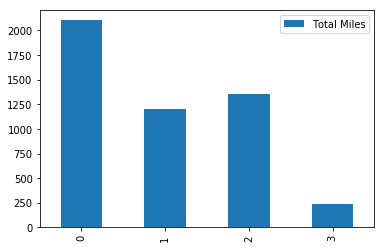

In [281]:
df.plot(kind = 'bar')

#### 2. 二此排序数据分析

##### 下载并合并分区数据

In [221]:
!docker exec master hadoop fs -cat /output/plates_secsort/part-00000 > \
./data/plates_secsort_result.txt

In [222]:
!docker exec master hadoop fs -cat /output/plates_secsort/part-00001 >> \
./data/plates_secsort_result.txt

In [223]:
!docker exec master hadoop fs -cat /output/plates_secsort/part-00002 >> \
./data/plates_secsort_result.txt

In [224]:
!cat ./data/plates_secsort_result.txt

鲁,鲁V75530,3	569
鲁,鲁V73930,2	549
鲁,鲁V75066,1	657
黑,黑ML1711,1	235
桂,桂J73138,2	456
桂,桂J73031,1	900
晋,晋M42387,3	432
晋,晋M41665,2	879
晋,晋M42529,1	790


##### 分析与可视化处理

In [269]:
def read_file(filename):
    result = []
    with open(filename) as f:
        for row in f:
            key, mile = row.split('\t')
            key = key.split(',')
            mile = int(mile)
            if len(key) >= 3:
                province = key[0]
                plate = key[1]
                order = key[2]
                result.append([province, plate, order, mile])
    return result

In [265]:
result = read_file('./data/plates_secsort_result.txt')

In [266]:
import pandas as pd

In [270]:
df = pd.DataFrame(result, columns = ['Province','Plate','Order', 'Mile'])
df

,Province,Plate,Order,Mile
0,鲁,鲁V75530,3,569
1,鲁,鲁V73930,2,549
2,鲁,鲁V75066,1,657
3,黑,黑ML1711,1,235
4,桂,桂J73138,2,456
5,桂,桂J73031,1,900
6,晋,晋M42387,3,432
7,晋,晋M41665,2,879
8,晋,晋M42529,1,790


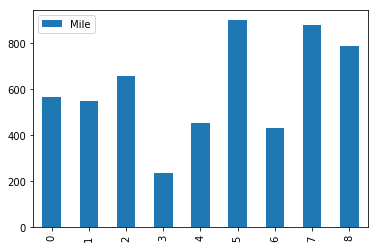

In [268]:
df.plot(kind = 'bar')